# Preparation

In [11]:
# Import libraries
import os
import glob
import pydicom as dicom
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [12]:
# Import custom definitions
from definitions import *

print(f"Dataset path: {data_root}")
print(f"Meta path: {meta_path}")
print(f"Mass training data path: {new_mass_train_path}")
print(f"Mass test data path: {new_mass_test_path}")

Dataset path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688
Meta path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\metadata.csv
Mass training data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_train_set.csv
Mass test data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_test_set.csv


### Retreive mass datasets

In [13]:
# Load updated mass datasets
new_mass_train = pd.read_csv(new_mass_train_path)
new_mass_test = pd.read_csv(new_mass_test_path)

In [14]:
new_mass_train.head(2)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC\07-20-2016-DDSM-...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO\07-20-2016-DDSM...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...


In [15]:
new_mass_test.head(2)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC\10-04-2016-DDSM-NA-3...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO\10-04-2016-DDSM-NA-...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...


### Image processing

In [22]:
def image_processor(image_path, target_size):
    path = os.path.join(data_root,'CBIS-DDSM', image_path)
    ds = dicom.dcmread(path)
    ds = ds.pixel_array
    ds_2d = ds.astype(float)
    ds_2d_scaled = (np.maximum(ds_2d, 0) / ds_2d.max()) * 255.0
    ds_2d_scaled = np.uint8(ds_2d_scaled)
    ds_2d_scaled = cv2.cvtColor(ds_2d_scaled, cv2.COLOR_BGR2RGB)
    ds_2d_scaled = cv2.resize(ds_2d_scaled, (target_size[1], target_size[0]))
    ds_2d_scaled = ds_2d_scaled.astype(float) / 255.0
    return ds_2d_scaled

In [27]:
# Merge mass_train and mass_test datasets
merged_mass = pd.concat([new_mass_train, new_mass_test], axis=0)

In [28]:
# Check for null values
merged_mass.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               60
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [29]:
# Fill missing values using backwards fill
merged_mass['mass shape'] = merged_mass['mass shape'].bfill()
merged_mass['mass margins'] = merged_mass['mass margins'].bfill()

# Re-check the number of missing values
merged_mass.isnull().sum()

patient_id                 0
breast_density             0
left or right breast       0
image view                 0
abnormality id             0
abnormality type           0
mass shape                 0
mass margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [30]:
# Define the target size
target_size = (224, 224, 3)

# Add pixel colour information by applying the image_processor function
merged_mass['processed images'] = merged_mass['image file path'].apply(
    lambda x: image_processor(x, target_size))

In [31]:
merged_mass['processed images'].head(2)

0    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
1    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
Name: processed images, dtype: object

In [33]:
# Create a binary mapper
class_mapper = {
    'MALIGNANT': 1,
    'BENIGN': 0,
    'BENIGN_WITHOUT_CALLBACK': 0
}

# Convert the 'processed images' column to an array
X_resized = np.array(merged_mass['processed images'].tolist())

# Apply the class mapper to the 'pathology' column
merged_mass['labels'] = merged_mass['pathology'].replace(class_mapper)
num_classes = len(merged_mass['labels'].unique())

C:\Users\lejam\AppData\Local\Temp\ipykernel_37112\2145462704.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_mass['labels'] = merged_mass['pathology'].replace(class_mapper)


In [34]:
# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_resized, merged_mass['labels'].values, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1356, 224, 224, 3)
X_test shape: (340, 224, 224, 3)
y_train shape: (1356, 2)
y_test shape: (340, 2)


# CNN Architecture

In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.applications import InceptionResNetV2
from keras.utils import plot_model

In [37]:
# Augment training data using various transformations
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

# Apply augmentation to training data
image_size=224
mode = InceptionResNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Freeze all layers except the last 5 so the model retains general visual features from ImageNet,
# while allowing the last layers to fine-tune and adapt to the new task-specific dataset
for layer in mode.layers[:-5]:
    layer.trainable = False

### Model architecture and training

In [38]:
# instantiate CNN model
model = tf.keras.Sequential([
    mode,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(2, activation='softmax')
])

# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Nadam(learning_rate=0.0001),
    metrics=['accuracy'])

# train model
history = model.fit(
    X_train, y_train, validation_data = (X_test, y_test), epochs=10 , batch_size=75)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.5594 - loss: 3.5922 - val_accuracy: 0.5735 - val_loss: 3.1638
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.7686 - loss: 2.9090 - val_accuracy: 0.6000 - val_loss: 3.2300
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.8588 - loss: 2.6059 - val_accuracy: 0.6265 - val_loss: 2.8966
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.9466 - loss: 2.3246 - val_accuracy: 0.6265 - val_loss: 2.8233
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.9835 - loss: 2.1175 - val_accuracy: 0.6500 - val_loss: 2.7320
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.9921 - loss: 1.9578 - val_accuracy: 0.6559 - val_loss: 2.5788
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.9971 - loss: 1.8062 - val_accuracy: 0.6206 - val_loss: 2.5477
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.9931 - loss: 1.7073 - val_accuracy: 0.6176 - v

### Evaluation

In [40]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6622 - loss: 2.2362


[2.2918169498443604, 0.6558823585510254]

### Report

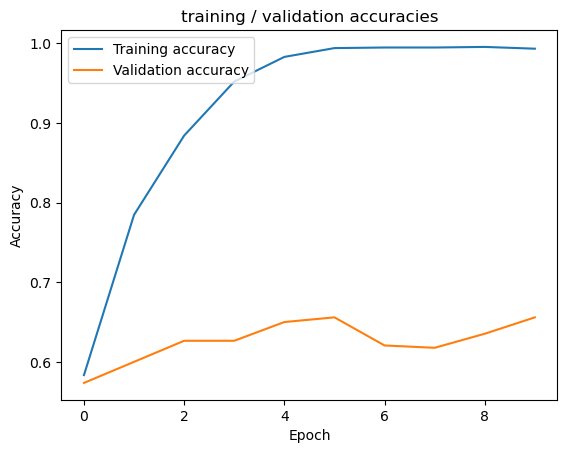

In [41]:
import matplotlib.pyplot as plt

# Visualise model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

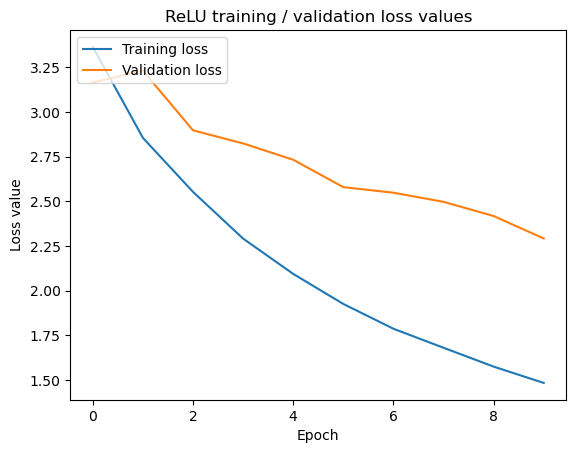

In [42]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Summary

This practice focuses on processing the CBIS-DDSM dataset, where image paths (i.e., 'image file path', 'cropped image file path', and 'ROI mask file path' columns in both the mass_train and mass_test datasets) were corrected using the UpdateInfo.ipynb file.

During preprocessing, the trainable data was prepared by merging the two updated mass datasets. It was observed that pixel arrays obtained from reading DICOM files were not compatible with OpenCV's cv2.imread() function. Since the model expects input data normalised to a range between 0 and 1, each pixel value needs to be divided by 255. However, DICOM images store pixel values as unsigned 16-bit integers, ranging from 0 to 65,535. Therefore, appropriate scaling was applied.

The processed data was used to train a simple CNN model. Although the model achieved over 99% training accuracy, its evaluation accuracy was around 66%. This discrepancy suggests that the low performance on evaluation is unlikely due to data quality, as the model still trained effectively on the preprocessed inputs.

In the next phase, a modified U-Net architecture will be implemented and optimised to improve generalisation and evaluation performance.